# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.8'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df[['Price', 'Volume']].values

In [3]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (568, 120, 2)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 2)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 2)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [14]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.00075
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()

model.add(Conv1D(input_shape=input_shape, filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(CuDNNLSTM(128))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(RepeatVector(num_out))

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(96, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(42, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 118, 96)           672       
_________________________________________________________________
batch_normalization_11 (Batc (None, 118, 96)           384       
_________________________________________________________________
activation_5 (Activation)    (None, 118, 96)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 118, 96)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 96)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 57, 128)           36992     
_________________________________________________________________
batch_normalization_12 (Batc (None, 57, 128)           512       
__________

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 568 samples, validate on 71 samples
Epoch 1/200
568/568 [==============================] - 3s 6ms/step - loss: 1.6031 - val_loss: 1.6969
Epoch 2/200
568/568 [==============================] - 0s 844us/step - loss: 1.3572 - val_loss: 1.4751
Epoch 3/200
568/568 [==============================] - 0s 848us/step - loss: 1.2375 - val_loss: 1.0413
Epoch 4/200
568/568 [==============================] - 0s 856us/step - loss: 1.1199 - val_loss: 1.0581
Epoch 5/200
568/568 [==============================] - 0s 838us/step - loss: 1.0377 - val_loss: 0.9806
Epoch 6/200
568/568 [==============================] - 0s 830us/step - loss: 0.9597 - val_loss: 0.8966
Epoch 7/200
568/568 [==============================] - 0s 854us/step - loss: 0.8831 - val_loss: 0.8419
Epoch 8/200
568/568 [==============================] - 0s 854us/step - loss: 0.8220 - val_loss: 0.7653
Epoch 9/200
568/568 [=====

568/568 [==============================] - 1s 974us/step - loss: 0.0130 - val_loss: 0.0075
Epoch 77/200
568/568 [==============================] - 1s 981us/step - loss: 0.0123 - val_loss: 0.0077
Epoch 78/200
568/568 [==============================] - 1s 972us/step - loss: 0.0113 - val_loss: 0.0086
Epoch 79/200
568/568 [==============================] - 1s 978us/step - loss: 0.0123 - val_loss: 0.0078
Epoch 80/200
568/568 [==============================] - 1s 972us/step - loss: 0.0109 - val_loss: 0.0102
Epoch 81/200
568/568 [==============================] - 1s 987us/step - loss: 0.0116 - val_loss: 0.0100
Epoch 82/200
568/568 [==============================] - 1s 980us/step - loss: 0.0115 - val_loss: 0.0076
Epoch 83/200
568/568 [==============================] - 1s 989us/step - loss: 0.0114 - val_loss: 0.0078
Epoch 84/200
568/568 [==============================] - 1s 975us/step - loss: 0.0109 - val_loss: 0.0077
Epoch 85/200
568/568 [==============================] - 1s 980us/step - loss:

568/568 [==============================] - 1s 976us/step - loss: 0.0057 - val_loss: 0.0097
Epoch 155/200
568/568 [==============================] - 1s 985us/step - loss: 0.0059 - val_loss: 0.0057
Epoch 156/200
568/568 [==============================] - 1s 956us/step - loss: 0.0057 - val_loss: 0.0083
Epoch 157/200
568/568 [==============================] - 1s 976us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 158/200
568/568 [==============================] - 1s 986us/step - loss: 0.0058 - val_loss: 0.0063
Epoch 159/200
568/568 [==============================] - 1s 976us/step - loss: 0.0051 - val_loss: 0.0056
Epoch 160/200
568/568 [==============================] - 1s 989us/step - loss: 0.0045 - val_loss: 0.0078
Epoch 161/200
568/568 [==============================] - 1s 979us/step - loss: 0.0061 - val_loss: 0.0112
Epoch 162/200
568/568 [==============================] - 1s 973us/step - loss: 0.0050 - val_loss: 0.0099
Epoch 163/200
568/568 [==============================] - 1s 961us/ste

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.004174261503894334
MSE Dev: 0.014420136534011443
MSE Test: 0.000828031418660438


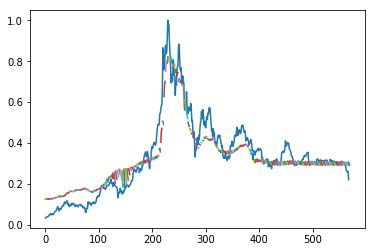

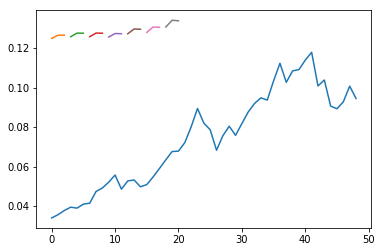

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

utils.plot_results_multiple(predicted_train.tolist()[:7], true_train[:49], num_out)

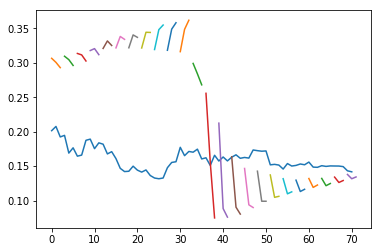

In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

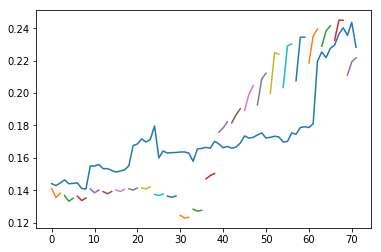

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [11]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.004200865584576662
MSE Dev: 0.014514010251161844
MSE Test: 0.0007726443581897607


In [12]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5044091710758377
Acc Dev: 0.4714285714285714
Acc Test: 0.6197183098591549


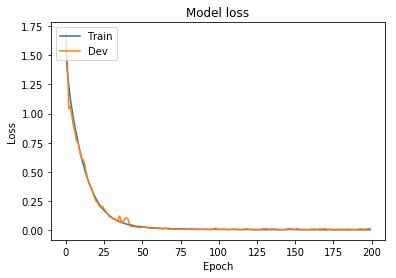

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

In [23]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 500
batch_size = 32

model = Sequential()

model.add(Conv1D(input_shape=input_shape, filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(CuDNNLSTM(128))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(RepeatVector(num_out))

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(96, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(42, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 118, 96)           672       
_________________________________________________________________
batch_normalization_21 (Batc (None, 118, 96)           384       
_________________________________________________________________
activation_9 (Activation)    (None, 118, 96)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 118, 96)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 59, 96)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 57, 128)           36992     
_________________________________________________________________
batch_normalization_22 (Batc (None, 57, 128)           512       
__________

In [24]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 500 epochs, 32 batch size
Train on 568 samples, validate on 71 samples
Epoch 1/500
568/568 [==============================] - 3s 5ms/step - loss: 1.8456 - val_loss: 1.5972
Epoch 2/500
568/568 [==============================] - 1s 1ms/step - loss: 1.3842 - val_loss: 1.1172
Epoch 3/500
568/568 [==============================] - 1s 1ms/step - loss: 1.2443 - val_loss: 1.0397
Epoch 4/500
568/568 [==============================] - 1s 1ms/step - loss: 1.1214 - val_loss: 0.9440
Epoch 5/500
568/568 [==============================] - 1s 991us/step - loss: 0.9991 - val_loss: 0.8733
Epoch 6/500
568/568 [==============================] - 1s 1ms/step - loss: 0.9142 - val_loss: 0.8048
Epoch 7/500
568/568 [==============================] - 1s 1ms/step - loss: 0.8287 - val_loss: 0.7274
Epoch 8/500
568/568 [==============================] - 1s 998us/step - loss: 0.7531 - val_loss: 0.7208
Epoch 9/500
568/568 [==============================] - 1s 1ms/step - loss: 0.6839 - 

568/568 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 80/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.1213
Epoch 81/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0219
Epoch 82/500
568/568 [==============================] - 1s 996us/step - loss: 0.0102 - val_loss: 0.0082
Epoch 83/500
568/568 [==============================] - 1s 992us/step - loss: 0.0115 - val_loss: 0.0119
Epoch 84/500
568/568 [==============================] - 1s 999us/step - loss: 0.0108 - val_loss: 0.0309
Epoch 85/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0095 - val_loss: 0.0548
Epoch 86/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0440
Epoch 87/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0162
Epoch 88/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0084 - val_

Epoch 158/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 159/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0138
Epoch 160/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 161/500
568/568 [==============================] - 1s 994us/step - loss: 0.0074 - val_loss: 0.0114
Epoch 162/500
568/568 [==============================] - 1s 994us/step - loss: 0.0056 - val_loss: 0.0092
Epoch 163/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0174
Epoch 164/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0113
Epoch 165/500
568/568 [==============================] - 1s 987us/step - loss: 0.0073 - val_loss: 0.0256
Epoch 166/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0594
Epoch 167/500
568/568 [==============================] - 1s 1ms/ste

Epoch 237/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 238/500
568/568 [==============================] - 1s 997us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 239/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0117
Epoch 240/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 241/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0105
Epoch 242/500
568/568 [==============================] - 1s 997us/step - loss: 0.0058 - val_loss: 0.0120
Epoch 243/500
568/568 [==============================] - 1s 994us/step - loss: 0.0057 - val_loss: 0.0065
Epoch 244/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0175
Epoch 245/500
568/568 [==============================] - 1s 997us/step - loss: 0.0068 - val_loss: 0.0088
Epoch 246/500
568/568 [==============================] - 1s 1ms/s

568/568 [==============================] - 1s 997us/step - loss: 0.0037 - val_loss: 0.0116
Epoch 316/500
568/568 [==============================] - 1s 998us/step - loss: 0.0042 - val_loss: 0.0166
Epoch 317/500
568/568 [==============================] - 1s 990us/step - loss: 0.0041 - val_loss: 0.0381
Epoch 318/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0153
Epoch 319/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0195
Epoch 320/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0147
Epoch 321/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0103
Epoch 322/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0406
Epoch 323/500
568/568 [==============================] - 1s 998us/step - loss: 0.0036 - val_loss: 0.0135
Epoch 324/500
568/568 [==============================] - 1s 1ms/step - loss: 0.

568/568 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0297
Epoch 395/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0316
Epoch 396/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0313
Epoch 397/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0256
Epoch 398/500
568/568 [==============================] - 1s 994us/step - loss: 0.0031 - val_loss: 0.0287
Epoch 399/500
568/568 [==============================] - 1s 999us/step - loss: 0.0031 - val_loss: 0.0318
Epoch 400/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0171
Epoch 401/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0207
Epoch 402/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 403/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0038

568/568 [==============================] - 1s 997us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 474/500
568/568 [==============================] - 1s 993us/step - loss: 0.0024 - val_loss: 0.0092
Epoch 475/500
568/568 [==============================] - 1s 999us/step - loss: 0.0023 - val_loss: 0.0162
Epoch 476/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0171
Epoch 477/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0118
Epoch 478/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0085
Epoch 479/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0096
Epoch 480/500
568/568 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 481/500
568/568 [==============================] - 1s 999us/step - loss: 0.0020 - val_loss: 0.0113
Epoch 482/500
568/568 [==============================] - 1s 1ms/step - loss: 0.

In [25]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0032366127624681323
MSE Dev: 0.02421482825212113
MSE Test: 0.012515761566006324


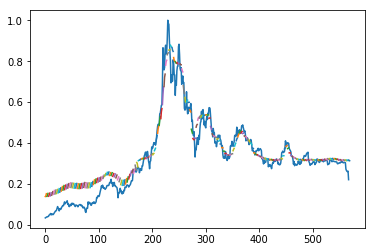

In [26]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

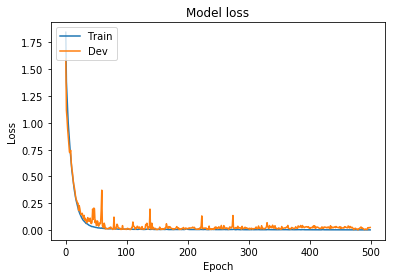

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

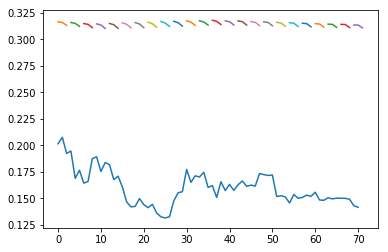

In [28]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

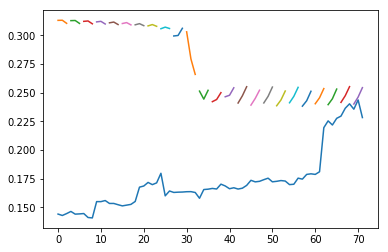

In [29]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [30]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5485008818342152
Acc Dev: 0.5
Acc Test: 0.5352112676056338
